Loading the dataset
At the moment we need to load the annotations directly from the database. We can replace this code with loading the csv file once the challenge is released

In [2]:
import numpy as np
import pandas as pd
from hcai_datasets.hcai_nova_dynamic.nova_db_handler import NovaDBHandler
from matplotlib.backends.backend_pdf import PdfPages

# Database Config file
db_cfg_path = '../../.configs/nova/nova_db.cfg'

# Sets
sessions_test = [f'recording{i:02d}' for i in range(1,7)]
sessions_train = [f'recording{i:02d}' for i in range(7,29)]

# Annotators
annotators = ['liechtensteinaugust','reineckermarcleon', 'fabianmaurer']

# Roles
roles = ['subjectPos1', 'subjectPos2', 'subjectPos3', 'subjectPos4']

# Schemes
scheme_consensus = 'backchannel_consensuality'
scheme_nonverbal = 'backchannel_nonverbal'
scheme_paraverbal = 'backchannel_paraverbal'
scheme_verbal = 'backchannel_verbal'

# Database handler
db_handler = NovaDBHandler(db_cfg_path)

# Annos
consensus = {}
nonverbal = {}
paraverbal = {}
verbal = {}


# Loading
for s in sessions_train + sessions_test:
    for r in roles:
        for a in annotators:
            print(f'Loading anno {s} - {r} - {a}')
            consensus[(s, r, a)] = db_handler.get_annos(dataset='mpiiemo', scheme=scheme_consensus, session=s,annotator=a,roles=r)
            nonverbal[(s, r, a)] = db_handler.get_annos(dataset='mpiiemo', scheme=scheme_nonverbal, session=s,annotator=a,roles=r)
            paraverbal[(s, r, a)] = db_handler.get_annos(dataset='mpiiemo', scheme=scheme_paraverbal, session=s,annotator=a,roles=r)
            verbal[(s, r, a)] = db_handler.get_annos(dataset='mpiiemo', scheme=scheme_verbal, session=s,annotator=a,roles=r)

Loaded config from ../../.configs/nova/nova_db.cfg:
---------------------
DB
	ip : 137.250.171.233
	port : 37317
	user : schildom
---------------------
Loading anno recording07 - subjectPos1 - liechtensteinaugust
No annotions found for 
	-annotator: liechtensteinaugust
	-scheme: backchannel_consensuality
	-session: recording07
	-role: subjectPos1
No annotions found for 
	-annotator: liechtensteinaugust
	-scheme: backchannel_nonverbal
	-session: recording07
	-role: subjectPos1
No annotions found for 
	-annotator: liechtensteinaugust
	-scheme: backchannel_paraverbal
	-session: recording07
	-role: subjectPos1
No annotions found for 
	-annotator: liechtensteinaugust
	-scheme: backchannel_verbal
	-session: recording07
	-role: subjectPos1
Loading anno recording07 - subjectPos1 - reineckermarcleon
No annotions found for 
	-annotator: reineckermarcleon
	-scheme: backchannel_consensuality
	-session: recording07
	-role: subjectPos1
No annotions found for 
	-annotator: reineckermarcleon
	-scheme:

In [3]:
# 0: consensus, 1: nonverbal, 2: paraverbal, 3: verbal
data_header = ['consensus', 'nonverbal', 'paraverbal', 'verbal']

# Dropping empty annos and convert rest to pandas dataframes
annos = [
    {key:pd.DataFrame(val) for key, val in consensus.items() if val != []},
    {key:pd.DataFrame(val) for key, val in nonverbal.items() if val != []},
    {key:pd.DataFrame(val) for key, val in paraverbal.items() if val != []},
    {key:pd.DataFrame(val) for key, val in verbal.items() if val != []}
]

# Add Partition to index
annos = [ {(('Train+Val',)+key if key[0] in sessions_train else ('Test',) + key) : val for key, val in x.items() } for x in annos]
print( annos)

[{('Train+Val', 'recording07', 'subjectPos2', 'liechtensteinaugust'):        from       to  id  conf meta
0     22.60    23.16   5   1.0     
1     23.76    25.04   8   1.0     
2     28.52    30.36   4   1.0     
3     32.64    33.64   5   1.0     
4     92.12    93.08   6   1.0     
5    105.72   107.72   3   1.0     
6    109.56   110.40   6   1.0     
7    111.32   111.68   5   1.0     
8    190.96   191.52   6   1.0     
9    194.36   195.00   6   1.0     
10   196.36   197.56   6   1.0     
11   198.16   199.36   5   1.0     
12   203.60   204.32   6   1.0     
13   205.76   206.36   6   1.0     
14   223.40   224.00   5   1.0     
15   224.72   225.80   5   1.0     
16   226.12   230.24   5   1.0     
17   272.84   273.76   5   1.0     
18   311.60   312.84   5   1.0     
19   315.04   316.44   8   1.0     
20   317.12   318.60   5   1.0     
21   326.56   327.36   5   1.0     
22   330.28   331.24   6   1.0     
23   337.80   338.76   7   1.0     
24   376.68   377.80   3   1.0

In [4]:
def df_for_scheme(annos):
    df = pd.concat(annos)
    df = df.drop(columns=['conf', 'meta'])
    df.index.names = ['set', 'session', 'subject', 'annotator', 'id']
    df['dur'] = df['to'] - df['from']
    df = df.rename(columns={'id':'label'})
    return df

annos_stats = {n : df_for_scheme(annos[i]) for i,n in enumerate(data_header)}

# Map consensus label id to float value
annos_stats['consensus']['label'] = annos_stats['consensus']['label'].astype(float).replace(
    [0,1,2,3,4,5,6,7,8,9],
    [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,np.nan]
)

print(annos_stats)
print('Annos have been generated. Read for analysis')

{'consensus':                                                               from       to  \
set       session     subject     annotator           id                      
Train+Val recording07 subjectPos2 liechtensteinaugust 0      22.60    23.16   
                                                      1      23.76    25.04   
                                                      2      28.52    30.36   
                                                      3      32.64    33.64   
                                                      4      92.12    93.08   
...                                                            ...      ...   
Test      recording06 subjectPos4 fabianmaurer        96   1170.36  1170.56   
                                                      97   1181.88  1182.52   
                                                      98   1212.12  1213.28   
                                                      99   1220.24  1220.84   
                                      

Let`s generate some statistics...
We start with the general description of the dataframes

In [5]:
for k,v in annos_stats.items():
    print('----------------')
    print(v.describe())

----------------
               from            to         label           dur
count  21843.000000  21843.000000  21062.000000  21843.000000
mean     588.107489    589.772764      0.292672      1.665275
std      351.718913    351.777048      0.320357      1.496485
min        0.200000      1.600000     -1.000000      0.120000
25%      285.520000    285.960000      0.250000      0.760000
50%      572.760000    573.840000      0.250000      1.280000
75%      893.240000    894.480000      0.500000      2.040000
max     1301.440000   1301.880000      1.000000     25.080000
----------------
              from           to   label          dur
count  6064.000000  6064.000000  6064.0  6064.000000
mean    583.843555   585.709934     0.0     1.866379
std     350.792430   350.876424     0.0     1.531201
min       0.200000     1.640000     0.0     0.000000
25%     279.690000   281.430000     0.0     0.960000
50%     567.920000   569.860000     0.0     1.440000
75%     887.990000   889.620000     0

## Backchannel Modalities ##

Generate statistics for backchannel modalities. First we plot the label count and the average duration per session per annotation track.
Also we plot a combination of verbal and paraverbal backchannels since those might not be clearly differentiated by the annotators.

In [6]:
from matplotlib import pyplot as plt

def plot_dist_for_modality_schemes(schemes, partition, title='', file_name=None,  font_size = 20):
    '''Plot Dtaframe statistics
    :param scheme: List of annotation schemes to plot
    :param partition: Test or Train
    :param stat: The column with the data t o plot
    :param title: Optional title for the plot
    :param file_name: Optional filename to save the plot under
    :param font_size: Optional font size to use in the plot
    '''

    # create new dataframe
    df_plot_label = pd.DataFrame()
    df_plot_duration = pd.DataFrame()

    for scheme in schemes:
        df_filtered = annos_stats[scheme].loc[partition,:,:,:]
        df_grouped = df_filtered.droplevel('id').groupby(level=['session'])
        stats = df_grouped.describe()
        df_plot_label[scheme] = stats['label']['count']
        df_plot_duration[scheme] = stats['dur']['mean']

    # plotting
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,15))
    df_plot_label.rename(lambda x : x[-2:]).plot(kind='bar', ax=axes[0], fontsize=font_size, xlabel='')
    df_plot_duration.rename(lambda x : x[-2:]).plot(kind='bar', ax=axes[1], fontsize=font_size, xlabel='')

    axes[0].set_title(f'Label Count {title if title is not None else scheme}- {partition}' ,fontweight="bold", size=font_size)
    axes[1].set_title(f'Average Duration {title if title is not None else scheme}- {partition}' ,fontweight="bold", size=font_size)
    axes[1].set_xlabel('Session', fontsize=font_size)
    axes[0].set_ylabel('Count', fontsize=font_size)
    axes[1].set_ylabel('Duration', fontsize=font_size)
    axes[0].legend(prop = {'size' : 25}, bbox_to_anchor=(1, 1.03), loc='upper left')
    axes[1].get_legend().remove()
    plt.tight_layout()
    plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.35)


    # save as pdf
    if file_name:
        with PdfPages(file_name + '.pdf') as pdf:
            pdf.savefig(bbox_inches='tight')

    plt.show()

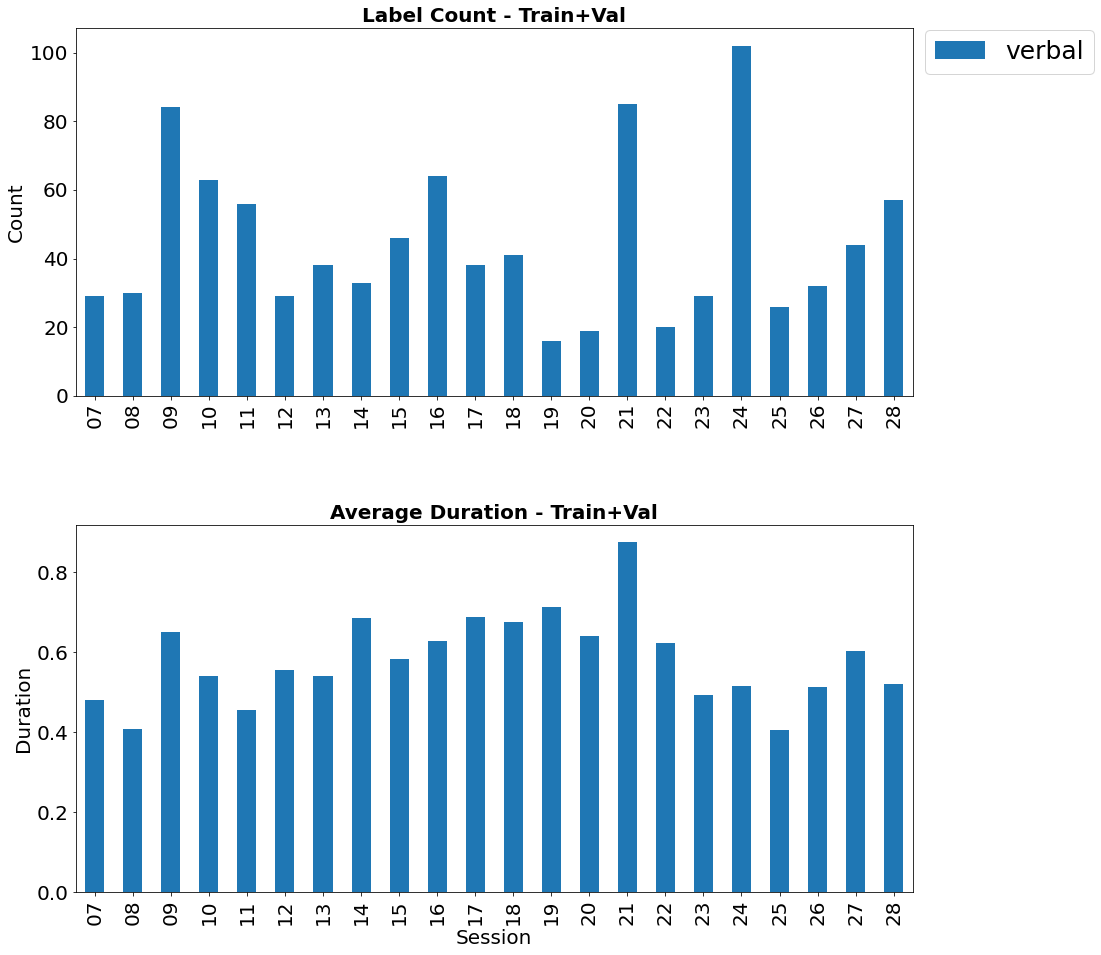

In [7]:
plot_dist_for_modality_schemes(['verbal'], 'Train+Val')

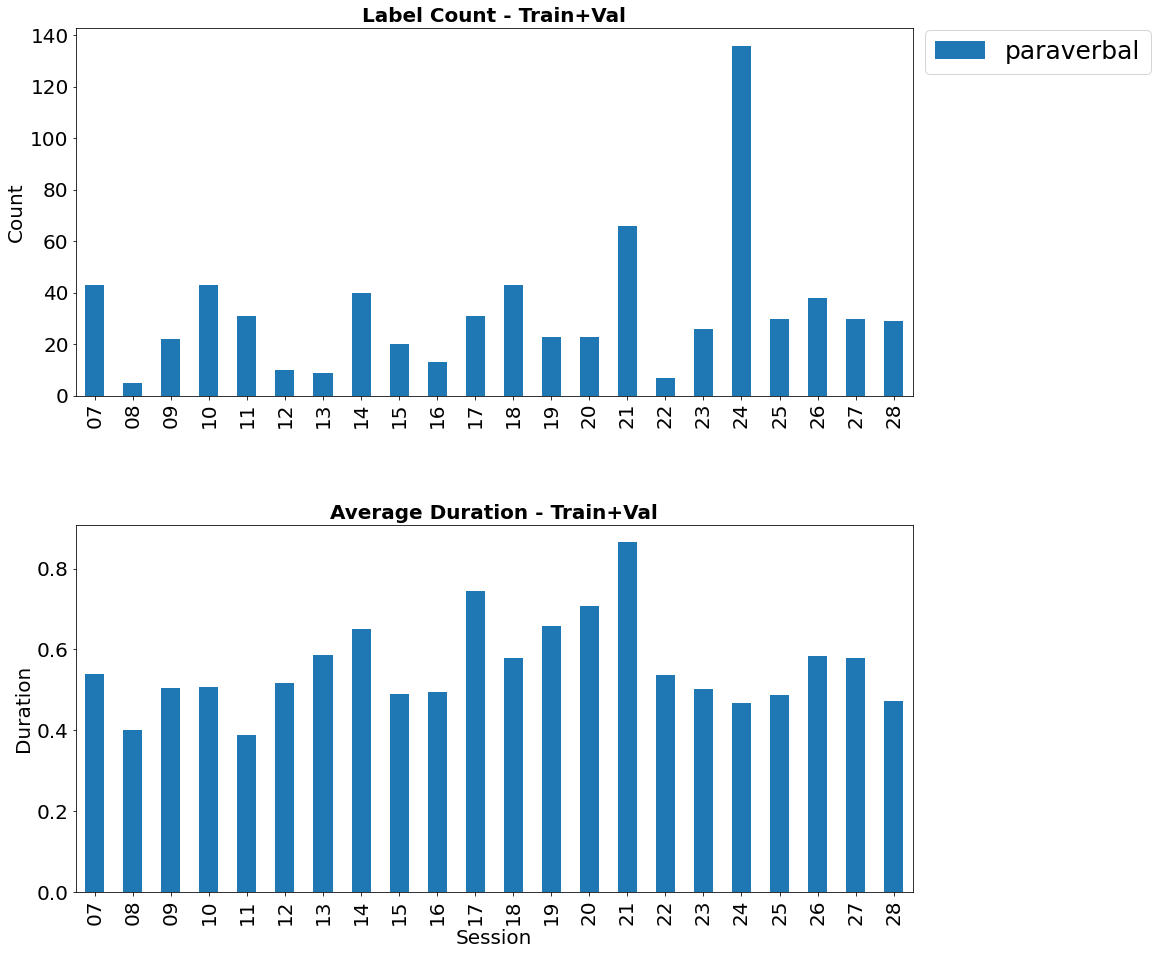

In [8]:
plot_dist_for_modality_schemes(['paraverbal'], 'Train+Val')

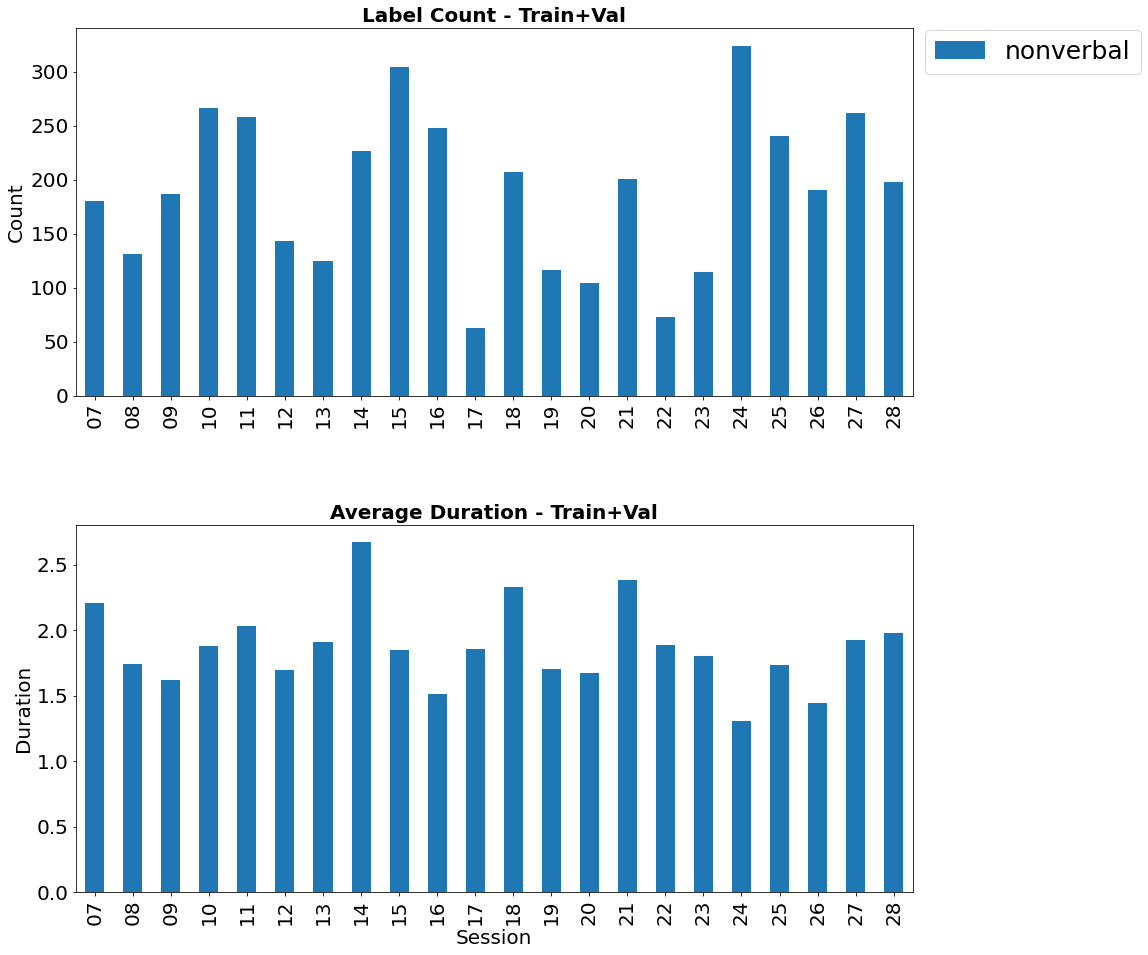

In [9]:
plot_dist_for_modality_schemes(['nonverbal'], 'Train+Val')

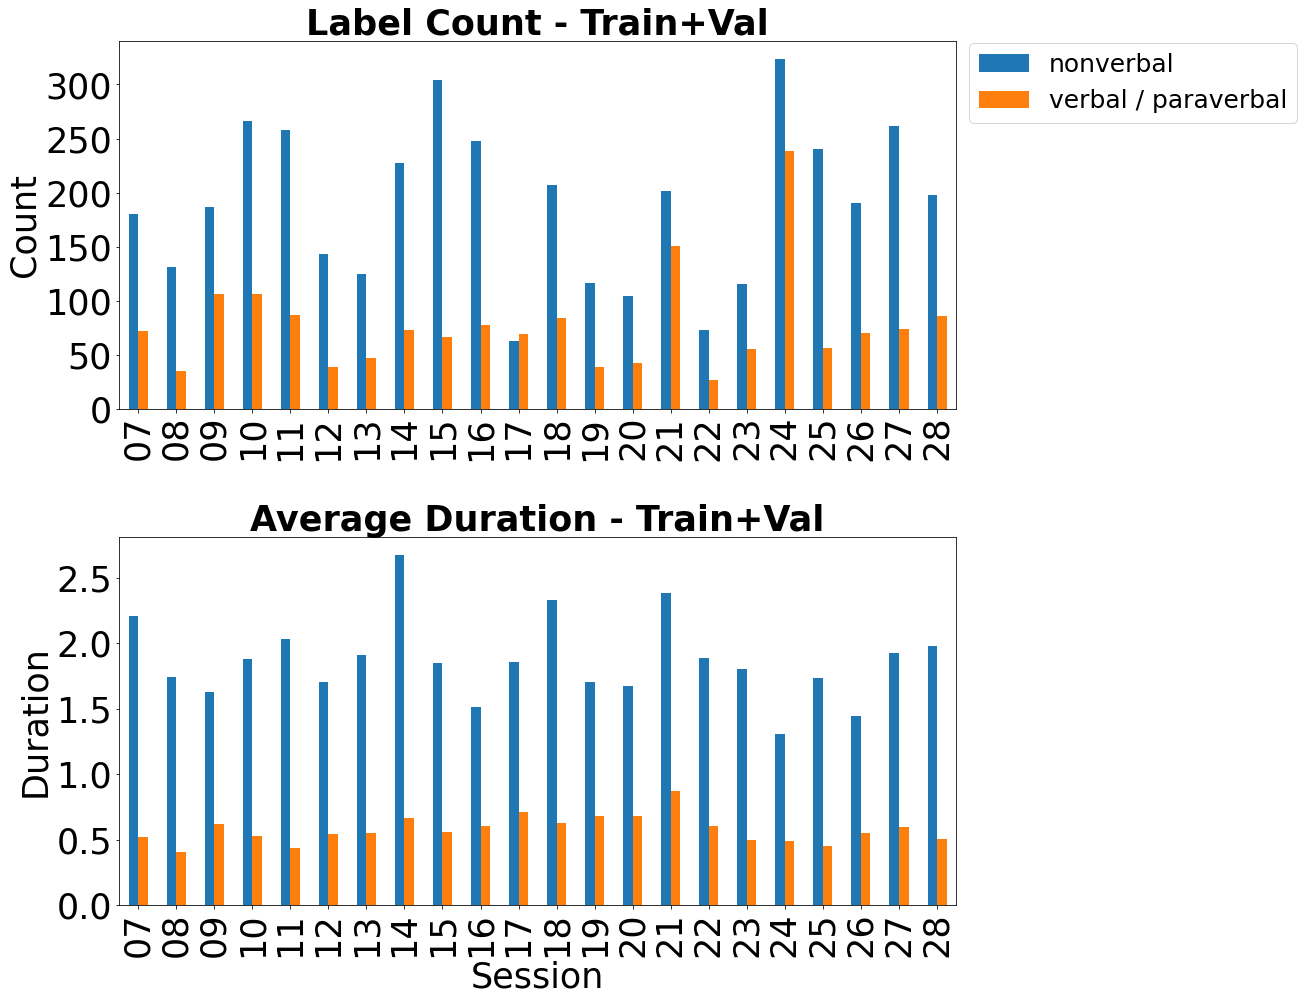

In [10]:
# combine nonverbal stats
annos_stats['verbal / paraverbal'] = pd.concat([annos_stats['paraverbal'], annos_stats['verbal']])
plot_dist_for_modality_schemes(['nonverbal', 'verbal / paraverbal'], 'Train+Val', title='', file_name='bc_stats', font_size=35)

## Backchannel Consensuality
In the following we first generate an overeview of the data

In [11]:
# Generate Stats for Train+Val
df_train = annos_stats['consensus'].loc['Train+Val',:,:,:]
df_train.droplevel('id').drop(columns=['from', 'to']).groupby(level=['session']).describe()

label                                                      dur  \
              count      mean       std   min   25%   50%   75%  max   count   
session                                                                        
recording07   601.0  0.253328  0.346093 -1.00  0.25  0.25  0.50  1.0   603.0   
recording08   429.0  0.163170  0.256131 -0.75  0.00  0.00  0.25  1.0   441.0   
recording09   724.0  0.236878  0.343886 -1.00  0.00  0.25  0.50  1.0   726.0   
recording10   944.0  0.223252  0.330312 -1.00  0.00  0.25  0.50  1.0   948.0   
recording11   840.0  0.262202  0.313459 -1.00  0.25  0.25  0.50  1.0   843.0   
recording12   469.0  0.233475  0.344553 -1.00  0.00  0.25  0.25  1.0   474.0   
recording13   419.0  0.158711  0.414872 -1.00  0.00  0.25  0.50  1.0   420.0   
recording14   762.0  0.341864  0.286167 -1.00  0.25  0.25  0.50  1.0   762.0   
recording15   963.0  0.305556  0.255710 -1.00  0.25  0.25  0.50  1.0   966.0   
recording16   811.0  0.296239  0.315771 -1.00  0.00  0.25  0.50  1.0   813.0   
recording17   320.0  0.260937  0.303257 -1.00  0.00  0.25  0.50  1.0   321.0   
recording18   689.0  0.314949  0.176904 -0.50  0.25  0.25  0.50  1.0   690.0   
recording19   384.0  0.335938  0.269968 -1.00  0.25  0.25  0.50  1.0   384.0   
recording20   388.0  0.151418  0.388935 -1.00  0.25  0.25  0.25  1.0   390.0   
recording21   789.0  0.339354  0.306343 -1.00  0.25  0.25  0.50  1.0   804.0   
recording22   231.0  0.341991  0.262577 -0.50  0.25  0.25  0.50  1.0   243.0   
recording23   414.0  0.408213  0.290641 -0.50  0.25  0.25  0.50  1.0   426.0   
recording24  1255.0  0.353586  0.299400 -1.00  0.25  0.25  0.50  1.0  1275.0   
recording25   705.0  0.274468  0.259453 -1.00  0.00  0.25  0.50  1.0   750.0   
recording26   627.0  0.181419  0.342482 -1.00  0.00  0.25  0.25  1.0   654.0   
recording27   803.0  0.352117  0.404350 -1.00  0.25  0.25  0.50  1.0   846.0   
recording28   658.0  0.327888  0.426386 -1.00  0.25  0.25  0.50  1.0   684.0   

                                                                
                 mean       std   min   25%   50%   75%    max  
session                                                         
recording07  2.055124  2.200769  0.24  0.92  1.36  2.32  20.56  
recording08  1.615238  1.943972  0.16  0.68  1.00  1.76  15.36  
recording09  1.431405  1.287874  0.20  0.72  1.14  1.72  12.68  
recording10  1.682996  1.416270  0.28  0.88  1.32  2.08  13.24  
recording11  1.903915  2.197120  0.16  0.88  1.40  1.96  25.08  
recording12  1.609367  1.310298  0.24  0.80  1.20  1.92   8.32  
recording13  1.770857  1.392065  0.24  0.88  1.36  2.17   8.84  
recording14  2.486142  1.948357  0.24  1.16  1.88  3.28  10.72  
recording15  1.788820  1.190012  0.20  1.08  1.52  2.16  12.48  
recording16  1.462878  1.131060  0.24  0.84  1.20  1.64  10.04  
recording17  1.420935  1.297575  0.32  0.68  1.08  1.60  10.08  
recording18  2.174435  1.683904  0.40  1.12  1.60  2.80  12.84  
recording19  1.616563  0.899163  0.40  1.00  1.44  2.00   6.28  
recording20  1.500615  0.819760  0.40  0.88  1.32  1.80   4.16  
recording21  2.038209  1.596710  0.48  1.04  1.54  2.60  14.20  
recording22  1.799506  1.417797  0.44  0.88  1.36  2.52   8.84  
recording23  1.566197  1.063495  0.20  0.88  1.28  2.04   5.84  
recording24  1.150494  0.839742  0.20  0.60  0.88  1.44   6.96  
recording25  1.716640  1.426333  0.20  0.92  1.32  2.00  12.28  
recording26  1.349541  1.086822  0.28  0.68  1.08  1.60   8.88  
recording27  1.846950  1.192146  0.28  0.92  1.60  2.44   6.76  
recording28  1.811754  1.448567  0.16  0.80  1.40  2.41   9.20

In [12]:
# Generate Stats for test
df_test = annos_stats['consensus'].loc['Test',:,:,:]
df_test.droplevel('id').drop(columns=['from', 'to']).groupby(level=['session']).describe()

label                                                     dur  \
              count      mean       std   min   25%   50%  75%  max   count   
session                                                                       
recording01  1080.0  0.323148  0.291359 -1.00  0.25  0.25  0.5  1.0  1137.0   
recording02   585.0  0.265812  0.310466 -1.00  0.00  0.25  0.5  1.0   663.0   
recording03  1553.0  0.323889  0.306931 -1.00  0.25  0.25  0.5  1.0  1656.0   
recording04  1650.0  0.300303  0.280588 -0.75  0.00  0.25  0.5  1.0  1812.0   
recording05   848.0  0.228774  0.371455 -1.00  0.00  0.25  0.5  1.0   945.0   
recording06  1121.0  0.372881  0.293928 -1.00  0.25  0.25  0.5  1.0  1167.0   

                                                                
                 mean       std   min   25%   50%   75%    max  
session                                                         
recording01  1.694248  1.380060  0.12  0.80  1.36  2.04   9.96  
recording02  1.120543  0.909929  0.16  0.56  0.88  1.40   8.40  
recording03  1.814420  1.721306  0.16  0.76  1.36  2.24  16.04  
recording04  1.382517  1.395613  0.16  0.48  0.96  1.80  12.48  
recording05  1.604317  1.897297  0.24  0.60  0.96  1.88  19.60  
recording06  1.564216  1.271135  0.20  0.64  1.24  2.00   7.96

To display the distribution of the consensuality labels we use a histogram plot.
Preliminarily we also rely on the annotations from August to create the plot since we do not have all annotations yet

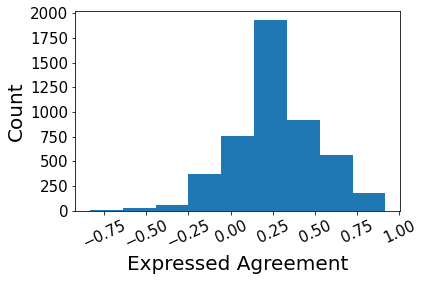

In [13]:
#plot
# Merge consensus annotations by averaging over annotators
df_train_merged = df_train.groupby(level=[0,1,3]).mean()
axes = df_train_merged['label'].plot.hist(bins=9)

plt.xticks(fontsize=15, rotation=25)
plt.yticks(fontsize=15, rotation=0)
plt.xlabel('Expressed Agreement', fontsize=20)
plt.ylabel('Count', fontsize=20)

# save as pdf
plt.tight_layout()
with PdfPages('bc_agreement_stats.pdf') as pdf:
    pdf.savefig()
plt.show()

Plotting the statistics for backchannel consensuality


In [14]:
tmp = df_train.groupby(level=['session', 'subject', 'id'])
for key, item in tmp:
    print(tmp.get_group(key), "\n\n")
#tmp['id'].aggregate('')


                                                from     to  label   dur
session     subject     annotator           id                          
recording07 subjectPos2 liechtensteinaugust 0   22.6  23.16   0.25  0.56
                        reineckermarcleon   0   22.6  23.16   0.00  0.56
                        fabianmaurer        0   22.6  23.16   0.25  0.56 


                                                 from     to  label   dur
session     subject     annotator           id                           
recording07 subjectPos2 liechtensteinaugust 1   23.76  25.04    1.0  1.28
                        reineckermarcleon   1   23.76  25.04    0.0  1.28
                        fabianmaurer        1   23.76  25.04    0.5  1.28 


                                                 from     to  label   dur
session     subject     annotator           id                           
recording07 subjectPos2 liechtensteinaugust 2   28.52  30.36   0.00  1.84
                        reineckermarc

### Backchannel consesuality modality distribution

The following statistics are showing how much each modality contributed to the respective backchannel consensuality labels


In [51]:
df_consensus = annos_stats['consensus']

# Adding the consensus labels for each annotator as a separate column
for annotator in df_consensus.index.unique(level='annotator'):
    df_consensus[annotator] = df_consensus[df_consensus.index.get_level_values('annotator') == annotator]['label']

#df_consensus[df_consensus.index.unique(level='annotator')] = df_consensus.apply(lambda x: x['label'] if x.name == )

# Group dataframe by sessions, subject and label id
grouped_consensus_all = df_consensus.groupby(level=['session', 'subject', 'id']).mean().sort_index()

for modality in ['nonverbal', 'verbal', 'paraverbal']:
    # Get the annotated data for the respective modality
    df_modality =  annos_stats[modality].droplevel(['set', 'annotator']).sort_index().reset_index()

    # Iterate over all consensus annotations
    for idx, row in grouped_consensus_all.iterrows():
        # Get all matching entries for the given time interval
        matches = df_modality[
            (df_modality['session'] == idx[0]) &
            (df_modality['subject'] == idx[1]) &
            (df_modality['from'] >= row['from']) &
            (df_modality['to'] <= row['to'])
        ]

         # Count if we have an overlapping label for the respective time interval in the consensus annotations
        count = len(matches)
        grouped_consensus_all.loc[idx, modality] = count

grouped_consensus_all.to_csv('backchannel_agreement_modalities.csv')
print(df_consensus)

                                                              from       to  \
set       session     subject     annotator           id                      
Train+Val recording07 subjectPos2 liechtensteinaugust 0      22.60    23.16   
                                                      1      23.76    25.04   
                                                      2      28.52    30.36   
                                                      3      32.64    33.64   
                                                      4      92.12    93.08   
...                                                            ...      ...   
Test      recording06 subjectPos4 fabianmaurer        96   1170.36  1170.56   
                                                      97   1181.88  1182.52   
                                                      98   1212.12  1213.28   
                                                      99   1220.24  1220.84   
                                                    